<a href="https://colab.research.google.com/github/ngving22/Daily-Pennsylvanian-Analytics/blob/main/Article_Pull_%26_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Article Pull

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install PyJWT

#Imports
import jwt
import pandas as pd
from tqdm import tqdm
from bs4 import BeautifulSoup
import requests
import math



#API keys
# get keys from https://dpn.ceo.getsnworks.com/ceo/developer
dp_pk = 'pk_h7GGLu5SHOMa1gTJpbCGZgWi1H4iX6'
dp_secret = 'sk_P62YquYTjiuGLCcTPjoZckjqFk7QBA'
dp_encoded_jwt = jwt.encode({'pk': dp_pk}, dp_secret, algorithm='HS256')

st_pk = 'pk_cxprrNDEjFDHjZOF1HRxkgnBUOnUiC'
st_secret = 'sk_085yhKYRPUsQVieJ9ss6ovRfljRMn3'
st_encoded_jwt = jwt.encode({'pk': st_pk}, st_secret, algorithm='HS256')

In [ ]:
#Function to get number of items for a given property
def getItems(endpoint, jwt):
  per_page=1
  page = 1
  endpoint = endpoint.format(page, per_page)
  headers = {"Authorization": "Bearer " + jwt}
  response = requests.get(url=endpoint, headers= headers)
  totalItems = response.json()['total_items']
  return totalItems

#Item count endpoints
dp_count_endpoint = """https://dpn.ceo.getsnworks.com/v3/content?dir=desc&grid=false&
              keywords&order=published_at&page={}&per_page={}&status=published&
              type=article&workflow"""
st_count_endpoint = """https://dpn-34s.ceo.getsnworks.com/v3/content?dir=desc&grid=false&
              keywords&order=published_at&page={}&per_page={}&status=published&
              type=article&workflow"""

#Get item counts
dp_items = getItems(dp_count_endpoint, dp_encoded_jwt)
st_items = getItems(st_count_endpoint, st_encoded_jwt)

#Endpoints for article scrape
dp_article_endpoint = """https://dpn.ceo.getsnworks.com/v3/content?dir=desc&grid=false&
                keywords&order=published_at&page={}&per_page={}&status=published&
                type=article&workflow"""

st_article_endpoint = """https://dpn-34s.ceo.getsnworks.com/v3/content?dir=desc&grid=false&
                keywords&order=published_at&page={}&per_page={}&status=published&
                type=article&workflow"""

In [ ]:
#Function to get articles for a given property
def getArticles(article_endpoint, jwt, numItems, cutoff_date = '1990-01-01', source='unknown'):
  perPage = 100 #Pagesize per request
  cutoff_date = pd.to_datetime(cutoff_date) #'2021-11-1' end of dp dump

  #Empty lists for results
  ids = []
  titles = []
  title_url = []
  content = []
  slugs = []
  contentType = []
  published_dates = []
  srns = []
  authorIds = []

  headers = {"Authorization": "Bearer " + jwt}

  #Scrape loop. Progress bar just indicates max duration
  for i in tqdm(range(math.ceil(numItems/perPage))):

    #Parameters for request 
    endpoint = article_endpoint.format(i+1, perPage)
    
    #Request send
    res = requests.get(url=endpoint, headers= headers).json()

    #Parse response
    for item in res['items']:
      ids.append(item['id'])
      titles.append(item['title'])
      title_url.append(
          item['published_at'][0:4] + "/" + 
          item['published_at'][5:7] + "/" + 
          item['title_url'])
      slugs.append(item['slug'])
      srns.append(item['srn'].split(":")[3])
      try:
        authorIds.append(item['user_id'])
      except:
        authorIds.append(None)
      contentType.append(item['type'])
      soup = BeautifulSoup(item['content'])
      for script in soup(['script','style']):
          script.decompose()
      content.append(soup.get_text().replace(u'\xa0',u' ').replace("\n"," "))
      ts = pd.to_datetime(item['published_at'])
      published_dates.append(ts)

    # Break if cutoff date reached
    if ts < cutoff_date:
      break
    
    articles_df = pd.DataFrame(data={'id' : ids,
                                 'type' : contentType,
                                 'srn' : srns,
                                 'title': titles,
                                 'slug': slugs,
                                 'content': content, 
                                 'published_date': published_dates,
                                 "title_url":title_url})
    articles_df = articles_df[articles_df['type'] == 'article']
    articles_df.reset_index(inplace=True, drop=True)
    articles_df['source'] = source

  return articles_df

In [ ]:
#Get new dp articles
dp_articles = getArticles(dp_article_endpoint,
                          dp_encoded_jwt,
                          dp_items,
                          '2022-01-01',
                          'dp')

  1%|          | 12/1719 [00:20<49:02,  1.72s/it]


In [ ]:
#Get new street articles
st_articles = getArticles(st_article_endpoint,
                          st_encoded_jwt,
                          st_items,
                          '2022-01-01',
                          'st')

  1%|▏         | 4/289 [00:08<09:35,  2.02s/it]


In [ ]:
# old_articles_df = pd.read_csv('/content/DP_Article_Dump.csv', lineterminator='\n')
old_dp_articles_df = pd.read_csv('/content/drive/MyDrive/DP Analytics/Data/DP_Article_Dump.csv', lineterminator='\n')
old_dp_articles_df = old_dp_articles_df[old_dp_articles_df['type'] == 'article']
old_dp_articles_df['source'] = 'dp'

old_st_articles_df = pd.read_csv('/content/drive/MyDrive/DP Analytics/Data/34thstreet_dump.csv', lineterminator='\n')
old_st_articles_df = old_st_articles_df[old_st_articles_df['type'] == 'article']
old_st_articles_df['source'] = 'st'

In [ ]:
articles_df = pd.concat([old_dp_articles_df,
                         old_st_articles_df,
                         dp_articles,
                         st_articles]
                        ).drop_duplicates(subset=['id']  
                        ).reset_index(drop=True)

In [ ]:
articles_df

,id,type,srn,title,slug,content,published_date,title_url,source,Unnamed: 0
0,198746,article,abe444b4-e7c9-4352-9b89-d9d18063c42a,Vinay Khosla | What’s in a name?,names-white-college-cultural-ethnic,My name is Vinay. And it’s pronounced Viy-NEY ...,2021-11-16 05:27:38,2021/11/names-white-college-cultural-ethnic,dp,NaN
1,198830,article,f79490f3-9ec2-4696-84a8-bd12b6b8a5a3,Penn Medicine doctor Florencia Greer Polite Na...,penn-medicine-doctor-named-carol-emmott-fellow...,"Florencia Greer Polite, chief of the Division ...",2021-11-16 05:03:04,2021/11/penn-medicine-doctor-named-carol-emmot...,dp,NaN
2,198829,article,e8e24f25-819c-4947-aaa0-0a8158d3dd03,Former Phila. Health Commissioner who disposed...,former-philadelphia-comissioner-move-remains-t...,The Washington D.C. Health Department appointe...,2021-11-16 05:01:00,2021/11/former-philadelphia-comissioner-move-r...,dp,NaN
3,198812,article,aeadb51d-f860-49e7-a1fc-5cb4c5898c8d,Penn researchers find link between SNAP partic...,penn-med-researchers-find-food-assistance-can-...,Supplemental Nutrition Assistance Program part...,2021-11-16 04:58:13,2021/11/penn-med-researchers-find-food-assista...,dp,NaN
4,198813,article,ced3fb7e-fe8d-4a85-adf4-44ee77ec6759,CDC reports inaccurate COVID-19 vaccination ra...,center-for-disease-control-pennsylvania-covid-...,The Centers for Disease Control and Prevention...,2021-11-16 04:55:20,2021/11/center-for-disease-control-pennsylvani...,dp,NaN
...,...,...,...,...,...,...,...,...,...,...
103371,41518,article,a6f9746a-4b96-4ced-a0b6-5d9dc9b329f5,Planting the Seeds of Food Justice at Penn Farm,penn-farm-food-insecurity-community-garden-wel...,"In a remote corner of Penn Park, a woman sits ...",2022-01-25 18:17:24,2022/01/penn-farm-food-insecurity-community-ga...,st,NaN
103372,41508,article,d2fcebd8-7852-4267-99b3-791bcbf0a1fc,Reconnecting with My Roots,gardening-applesauce-apples-rural-farming-stud...,From my bedroom you can hear the trains runnin...,2022-01-25 17:00:00,2022/01/gardening-applesauce-apples-rural-farm...,st,NaN
103373,41500,article,165ef0bc-d9c2-4052-8622-b0bcd448c4af,TikTok's #TraumaDump: Why Trauma Can’t Be Just...,tiktok-trauma-dumping-mental-health-internet-s...,Nestled between countless dance and comedy vid...,2022-01-25 17:00:00,2022/01/tiktok-trauma-dumping-mental-health-in...,st,NaN
103374,41498,article,4a744aa0-1722-4e89-a950-12462cd7f163,Euphoria’s “Out of Touch” Finds Liberation in ...,rue-euphoria-aesthetics-privilege-love-perspec...,"Aesthetics, aesthetics, aesthetics. It's one o...",2022-01-25 15:22:09,2022/01/rue-euphoria-aesthetics-privilege-love...,st,NaN


# Article Google Analytics Pull


In [ ]:
#Imports
from oauth2client.service_account import ServiceAccountCredentials
from apiclient.discovery import build
import httplib2
import requests

import pandas as pd
from tqdm import tqdm

In [ ]:
#Client API key
!gdown --id '1TI561uOGwzHzwcVC56KbqrMn3TUWeRM3'

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1TI561uOGwzHzwcVC56KbqrMn3TUWeRM3
To: /content/analytics-api-1581487025251-ac904d31a17e.json
100% 2.38k/2.38k [00:00<00:00, 3.22MB/s]


In [ ]:
#Get urls of articles, needed to get analytics
# urls = []
# for srn in tqdm(articles_df['srn']):
#   r = requests.get('https://thedp.com/' + srn) 
#   urls.append(r.url)
# articles_df['realUrls'] = urls

urls = ["/article/" + title_url for title_url in articles_df['title_url']]
articles_df['url'] = ["/article/" + title_url for title_url in articles_df['title_url']]

## Get per-page statistics

In [ ]:
#Create service credentials
credentials = ServiceAccountCredentials.from_json_keyfile_name(
    '/content/analytics-api-1581487025251-ac904d31a17e.json',
    ['https://www.googleapis.com/auth/analytics.readonly'])

#Create a service object
http = credentials.authorize(httplib2.Http())
service = build('analytics', 'v4', http=http, discoveryServiceUrl=('https://analyticsreporting.googleapis.com/$discovery/rest'))

def getViews(pages, viewId, startDate = '2006-01-01', endDate = 'today'):
  response = service.reports().batchGet(
      body={
          'reportRequests': [
              {
                  'viewId': viewId, #Add View ID from GA
                  'dateRanges': [{'startDate': startDate, 'endDate': endDate}],
                  'metrics': [{'expression': 'ga:uniquePageviews'},
                              {'expression': 'ga:pageviews'}], 
                  'dimensions': [{"name": "ga:pagePath"}], #Get Pages
                  "dimensionFilterClauses" : [{
                      'filters' : {
                          "dimensionName" : "ga:pagePath",
                          "operator" : "IN_LIST",
                          "expressions" : pages
                      }
                  }],
                  'pageSize': 100000
              }]
      }
  ).execute()
  
  #create two empty lists that will hold our dimentions and sessions data
  data = []
    
  #Extract Data
  for report in response.get('reports', []):
 
      rows = report.get('data', {}).get('rows', [])
    
      for row in rows:
    
          url = row['dimensions'][0]
          uniquePageViews, pageViews = row['metrics'][0]['values']
          data.append((url, uniquePageViews, pageViews))

  return pd.DataFrame(data, columns=['url', 'uniquePageViews', 'pageViews']) 

In [ ]:
import datetime as DT
today = DT.date.today()

week_ago = today - DT.timedelta(days=7)

week_ago_str = str(week_ago)

month_ago = today - DT.timedelta(days=31)

month_ago_str = str(month_ago)

In [ ]:
def get_week_month_engagement(code):
  engagementDPWeek = getViews(urls, code, week_ago_str)
  engagementDPWeek['pageViewsWeek'] = pd.to_numeric(engagementDPWeek['pageViews'])

  engagementDPMonth = getViews(urls, code, month_ago_str)
  engagementDPMonth['pageViewsMonth'] = pd.to_numeric(engagementDPMonth['pageViews'])

  engagementDPWeek = engagementDPWeek.merge(
      articles_df[['url', 'title', 'published_date']], on='url')
  engagementDPMonth = engagementDPMonth.merge(
      articles_df[['url', 'title', 'published_date']], on='url')

  past_week = engagementDPWeek.sort_values(
    by='pageViewsWeek', ascending=False).head(
        20)[['title', 'pageViewsWeek', 'published_date']]
  
  past_month = engagementDPMonth.sort_values(
    by='pageViewsMonth', ascending=False).head(
        20)[['title', 'pageViewsMonth', 'published_date']]
    

  return past_week, past_month

In [ ]:
dp_past_week, dp_past_month = get_week_month_engagement('22050415')

In [ ]:
st_past_week, st_past_month = get_week_month_engagement('2741074')

In [ ]:
dp_past_week.head(6)

,title,pageViewsWeek,published_date
0,"Following public outcry, Penn lifts hold on fo...",17470,2022-04-12 21:22:25
1,Penn Law’s Amy Wax doubles down on racist comm...,7164,2022-01-27 06:18:29
2,Amy Wax repeats racist rhetoric on national te...,6058,2022-04-12 03:30:36
3,Liala Sofi & Allison Santa-Cruz | We believe y...,5309,2022-04-07 01:36:26
4,Valerie Wang & Varun Saraswathula | Mackenzie ...,3484,2022-04-07 02:04:32
5,"Penn's COVID-19 case count nearly doubles, rea...",3447,2022-04-06 04:38:04


In [ ]:
dp_past_month

,title,pageViewsMonth,published_date
13314,Wharton professor Sigal Barsade dies at 56,37246,2022-03-15 04:34:21
13051,Penn Rhodes Scholarship recipient files lawsui...,28238,2022-01-25 07:09:52
13413,"Following public outcry, Penn lifts hold on fo...",17474,2022-04-12 21:22:25
13315,Penn releases Class of 2026 regular decision r...,12808,2022-03-31 23:37:23
13266,Lia Thomas takes eighth place in her final swi...,10378,2022-03-19 23:16:44
13031,Penn Law’s Amy Wax doubles down on racist comm...,7986,2022-01-27 06:18:29
13428,Amy Wax repeats racist rhetoric on national te...,6058,2022-04-12 03:30:36
12915,"Five Guys, Raising Cane’s among five restauran...",6051,2021-11-04 05:21:25
13279,Penn Athletics announces construction on new $...,6004,2022-03-15 03:15:42
13253,Multiple gunshots fired outside McDonald’s at ...,5921,2022-03-16 03:30:11


In [ ]:
st_past_week.head(6)

,title,pageViewsWeek,published_date
1405,Are Instagram Sugar Daddies Legit?,1352,2020-11-01 23:49:11
1455,The Madonna–Whore Complex Puts Women in Danger,832,2021-01-26 19:00:00
1519,The Dark Side of Dating Apps,727,2021-02-09 13:32:55
1213,"Euphoria, Anxiety, and Intensity: The Reality ...",717,2020-03-04 00:43:15
1665,It’s Time to Hang Up the Term ”Wife Beater”,540,2021-07-28 16:27:24
2120,Sidechat to the Main Stage: A New App That Is ...,365,2022-04-05 13:41:51


In [ ]:
st_past_month

,title,pageViewsMonth,published_date
2813,Are Instagram Sugar Daddies Legit?,5659,2020-11-01 23:49:11
2884,The Madonna–Whore Complex Puts Women in Danger,3191,2021-01-26 19:00:00
2520,"Euphoria, Anxiety, and Intensity: The Reality ...",2592,2020-03-04 00:43:15
3177,It’s Time to Hang Up the Term ”Wife Beater”,1841,2021-07-28 16:27:24
2979,The Dark Side of Dating Apps,1646,2021-02-09 13:32:55
3292,'From Scratch' Shows John Mulaney In His Most ...,1283,2021-10-31 18:01:16
2231,These Brands Can Help You 'Try On' A Tattoo Be...,967,2019-09-12 03:20:05
3666,Life After Undergrad,779,2022-03-23 19:32:52
3189,A Guide to Philly's Quizzo Scene—aka 'Jeopardy...,778,2021-08-24 23:35:08
3694,Get to Know Penn's Oldest Stone(r)s,770,2022-03-22 14:20:38


In [ ]:
dp_past_week.reset_index(drop=True, inplace=True)
st_past_week.reset_index(drop=True, inplace=True)

result = pd.concat([dp_past_week.head(6), st_past_week.head(6)], axis = 1)

result.drop('published_date', axis=1, inplace=True)

result

,title,pageViewsWeek,title,pageViewsWeek
0,"Following public outcry, Penn lifts hold on fo...",17470,Are Instagram Sugar Daddies Legit?,1352
1,Penn Law’s Amy Wax doubles down on racist comm...,7164,The Madonna–Whore Complex Puts Women in Danger,832
2,Amy Wax repeats racist rhetoric on national te...,6058,The Dark Side of Dating Apps,727
3,Liala Sofi & Allison Santa-Cruz | We believe y...,5309,"Euphoria, Anxiety, and Intensity: The Reality ...",717
4,Valerie Wang & Varun Saraswathula | Mackenzie ...,3484,It’s Time to Hang Up the Term ”Wife Beater”,540
5,"Penn's COVID-19 case count nearly doubles, rea...",3447,Sidechat to the Main Stage: A New App That Is ...,365


## Get overall statistics

In [ ]:
#Imports
from oauth2client.service_account import ServiceAccountCredentials
from apiclient.discovery import build
import httplib2
import requests
import matplotlib.pyplot as plt


import pandas as pd
from tqdm import tqdm


In [ ]:
def getOverallStats(viewId, startDate = '2006-01-01', endDate = 'today'):
  response = service.reports().batchGet(
        body={
            'reportRequests': [
                {
                    'viewId': viewId, #Add View ID from GA
                    'dateRanges': [{'startDate': startDate, 'endDate': endDate}],
                    'metrics': [{'expression': 'ga:uniquePageviews'},
                                {'expression': 'ga:pageViews'},
                                {'expression': 'ga:bounceRate'},
                                {'expression': 'ga:avgTimeOnPage'}], 
                }]
        }
    ).execute()
    
  #Extract Data
  for report in response.get('reports', []):

      results = report.get('data', {}).get('rows', [])[0]['metrics'][0]['values']
      uniquePageViews, pageViews, bounceRate, avgPageTime= results
      return uniquePageViews, pageViews, bounceRate, avgPageTime

In [ ]:
import datetime as DT
today = DT.date.today()

def getRange(viewId, daySpan, spans):
  # daySpan: Number of days to aggregate over (eg, 7 for week)
  # of spans to calculate statistics for (eg, 4 for a month)
  stats = {}
  for i in range(spans):
    start = today - DT.timedelta(days=daySpan * (i+1))
    end = today - DT.timedelta(days=daySpan * (i))
    stats[str(end)] = getOverallStats(viewId,
                                      startDate = str(start),
                                      endDate = str(end))
  return stats

In [ ]:
dpRange = getRange('22050415', 7, 16)
dpRange

dpRange_df = pd.DataFrame(dpRange) 
dpRange_df = dpRange_df.T
dpRange_df.rename(columns={'': 'Date', 0 : 'UniquePageView', 1 : 'PageViews', 2 : 'BounceRate', 3 : "AvgTimeOnPage"}, inplace=True)

new_df = dpRange_df.iloc[[0,1,4,10]] 

time = ['This Week', 'Last Week', 'Past Month', 'Past Quarter']
new_df.insert(0, 'Time', time, True)

new_df





,Time,UniquePageView,PageViews,BounceRate,AvgTimeOnPage
2022-04-13,This Week,134530,149368,82.28388962084614,145.76357556398483
2022-04-06,Last Week,121392,135318,81.64427190124793,130.4567139835368
2022-03-16,Past Month,66745,75873,80.05424341733529,130.03832477281708
2022-02-02,Past Quarter,175835,196610,81.68317887954026,136.42085810702233


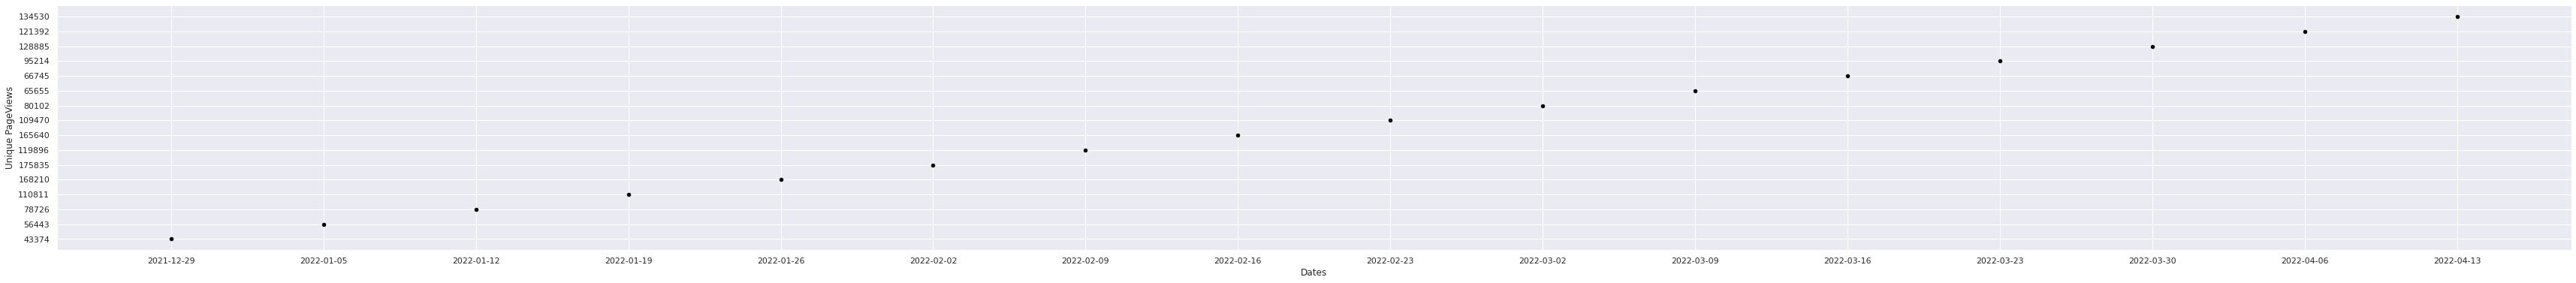

In [ ]:
import seaborn as sns

dpRange = getRange('22050415', 7, 16)
dpRange

dpRange_df = pd.DataFrame(dpRange) 
dpRange_df = dpRange_df.T

dpRange_df.drop(1, axis = 1, inplace = True)
dpRange_df.drop(2, axis = 1, inplace = True)
dpRange_df.drop(3, axis = 1, inplace = True)

dpRange_df.reset_index(inplace=True)
dpRange_df = dpRange_df.rename(columns = {'index':'Dates'})
dpRange_df = dpRange_df.rename(columns = {0:'Unique PageViews'})

x = dpRange_df.iloc[::-1]
q = x.reset_index()
q.drop('index', axis=1, inplace=True)

q.plot(kind = 'scatter', x = 'Dates', y = 'Unique PageViews', color = 
       'Black')
plt.show()


#z = sns.lineplot(data=q, x='Dates', y='Unique PageViews')
#plt.show()
#z.set_yticks(range(3))
#z.set_yticklabels(['150,000','100000','50000','0'])
#sns.set(rc = {'figure.figsize':(60,6)})



In [ ]:
stRange = getRange('22050415', 7, 16)
stRange

stRange_df = pd.DataFrame(stRange) 
stRange_df = stRange_df.T
stRange_df.rename(columns={'': 'Date', 0 : 'UniquePageView', 1 : 'PageViews', 2 : 'BounceRate', 3 : "AvgTimeOnPage"}, inplace=True)

new_df = stRange_df.iloc[[0,1,4,10]] 

time = ['This Week', 'Last Week', 'Past Month', 'Past Quarter']
new_df.insert(0, 'Time', time, True)

new_df

,Time,UniquePageView,PageViews,BounceRate,AvgTimeOnPage
2022-04-13,This Week,128767,143044,82.15967834577829,145.97105017623886
2022-04-06,Last Week,121392,135318,81.64427190124793,130.4567139835368
2022-03-16,Past Month,66745,75873,80.05424341733529,130.03832477281708
2022-02-02,Past Quarter,175835,196610,81.68317887954026,136.42085810702233


In [ ]:
def getViewChannels(viewId, startDate = '2006-01-01', endDate = 'today'):
  response = service.reports().batchGet(
          body={
              'reportRequests': [
                  {
                      'viewId': viewId, #Add View ID from GA
                      'dateRanges': [{'startDate': startDate, 'endDate': endDate}],
                      'metrics': [{'expression': 'ga:pageviews'}],
                      'dimensions': [{'name': 'ga:ChannelGrouping'}],
                  }]
          }
      ).execute()
      
  #Extract Data
  for report in response.get('reports', []):

      results = report.get('data', {}).get('rows', [])
      cleaned = [(x['dimensions'][0], x['metrics'][0]['values'][0]) for x in results]
      cleaned.sort(key = lambda x: int(x[1]), reverse=True) 
      return cleaned

In [ ]:
dpViewChannels = getViewChannels('22050415', '2022-01-01')
dpViewChannels

[('Organic Search', '830874'),
 ('Direct', '443644'),
 ('Social', '196684'),
 ('Referral', '109476'),
 ('Email', '2480'),
 ('Paid Search', '97'),
 ('(Other)', '61')]

In [ ]:
stViewChannels = getViewChannels('2741074', '2022-01-01')
stViewChannels

[('Organic Search', '226904'),
 ('Direct', '64680'),
 ('Referral', '27682'),
 ('Social', '16412'),
 ('Email', '221'),
 ('(Other)', '29')]

In [ ]:
def getViewSources(viewId, startDate = '2006-01-01', endDate = 'today'):
  response = service.reports().batchGet(
          body={
              'reportRequests': [
                  {
                      'viewId': viewId, #Add View ID from GA
                      'dateRanges': [{'startDate': startDate, 'endDate': endDate}],
                      'metrics': [{'expression': 'ga:pageviews',
                                  'expression': 'ga:users'}],
                      'dimensions': [{'name': 'ga:source'}],
                  }]
          }
      ).execute()
      
  #Extract Data
  for report in response.get('reports', []):

      results = report.get('data', {}).get('rows', [])
      cleaned = [(x['dimensions'][0], x['metrics'][0]['values'][0]) for x in results]
      cleaned.sort(key = lambda x: int(x[1]), reverse=True) 
      return cleaned

In [ ]:
dpViewSources1 = getViewSources('22050415', '2022-04-06', 'today')

dpViewSources2 = getViewSources('22050415', '2022-03-30', '2022-04-06')

dpViewSources3 = getViewSources('22050415', '2022-03-13', 'today')

dpViewSources4 = getViewSources('22050415', '2022-02-13', 'today')

df1 = pd.DataFrame(dpViewSources1)
df2 = pd.DataFrame(dpViewSources2)
df3 = pd.DataFrame(dpViewSources3)
df4 = pd.DataFrame(dpViewSources4)

df1.rename(columns={'': 'Date', 0 : 'Source', 1 : 'Users'}, inplace=True)
df2.rename(columns={'': 'Date', 0 : 'Source', 1 : 'Users'}, inplace=True)
df3.rename(columns={'': 'Date', 0 : 'Source', 1 : 'Users'}, inplace=True)
df4.rename(columns={'': 'Date', 0 : 'Source', 1 : 'Users'}, inplace=True)

result1 = pd.concat([df1.head(6), df2.head(6)], axis=1)
result2 = pd.concat([df3.head(6), df4.head(6)], axis=1)

finalResult = pd.concat([result1, result2], axis = 1)

finalResult


,Source,Users,Source,Users,Source,Users,Source,Users
0,google,43029,google,43662,google,148655,google,243016
1,(direct),24081,(direct),19533,(direct),87191,(direct),128774
2,t.co,5352,m.facebook.com,7669,m.facebook.com,15836,m.facebook.com,28254
3,m.facebook.com,4997,l.facebook.com,1155,news.google.com,8232,newsbreakapp.com,16502
4,news.google.com,3381,t.co,822,t.co,7245,t.co,11343
5,l.facebook.com,1060,lm.facebook.com,796,newsbreakapp.com,5190,news.google.com,10903


In [ ]:
stViewSources = getViewSources('2741074', '2022-01-01')
stViewSources
df = pd.DataFrame(stViewSources)
df.rename(columns={'': 'Date', 0 : 'Source', 1 : 'Users'}, inplace=True)
df.head(6)


stViewSources1 = getViewSources('2741074', '2022-04-06', 'today')

stViewSources2 = getViewSources('2741074', '2022-03-30', '2022-04-06')

stViewSources3 = getViewSources('2741074', '2022-03-13', 'today')

stViewSources4 = getViewSources('2741074', '2022-02-13', 'today')

df1 = pd.DataFrame(stViewSources1)
df2 = pd.DataFrame(stViewSources2)
df3 = pd.DataFrame(stViewSources3)
df4 = pd.DataFrame(stViewSources4)

df1.rename(columns={'': 'Date', 0 : 'Source', 1 : 'Users'}, inplace=True)
df2.rename(columns={'': 'Date', 0 : 'Source', 1 : 'Users'}, inplace=True)
df3.rename(columns={'': 'Date', 0 : 'Source', 1 : 'Users'}, inplace=True)
df4.rename(columns={'': 'Date', 0 : 'Source', 1 : 'Users'}, inplace=True)

result1 = pd.concat([df1.head(6), df2.head(6)], axis=1)
result2 = pd.concat([df3.head(6), df4.head(6)], axis=1)

finalResult = pd.concat([result1, result2], axis = 1)

finalResult


,Source,Users,Source,Users,Source,Users,Source,Users
0,google,14411,google,14578,google,53395,google,96404
1,(direct),4426,(direct),4982,(direct),18243,(direct),29967
2,m.facebook.com,336,m.facebook.com,290,m.facebook.com,983,m.facebook.com,2154
3,thedp.com,253,thedp.com,267,thedp.com,847,l.instagram.com,1743
4,t.co,170,l.instagram.com,171,l.instagram.com,672,thedp.com,1600
5,l.instagram.com,135,t.co,117,t.co,510,t.co,773
